In [1]:
## Mount Google Drive Data (If using Google Colaboratory)
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    print("Mounting Failed.")

Mounted at /content/drive


In [593]:
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd

In [609]:
def IDPP_solution(m,s,c):
    m3, c3 = m_initial(m,c)
    m_graph = MGraph()
    m_graph.build_graph(m3,s,c3)
    m_pairs = m_graph.get_edge_pairs()
    tree_set = [set(s)] #initialise a tree
    u_set = []

    while len(m_pairs) > 1:
        # find connected component k
        k = get_connected_componet(set(),set(m_pairs[0]),m_graph)
        if len(k) < 3:
            for n in k:
                m_graph.delNode(n)
            m_pairs = m_graph.get_edge_pairs()
        else:
            s_prime, u = get_S_prime_semi_universal(m3,s,c3,k)

            if not u: # empty set.. no phylogeny tree
                break
            else:
                u_set.append(u)
                print('u:')
                print(u)
                tree_set.append(s_prime)
                for n in u:
                    m_graph.delNode(n)
                m_pairs = m_graph.get_edge_pairs()
                print('Tree:')
                print(tree_set)

    m_new = m3.copy()

    for s_set_i, s_set in enumerate(tree_set[1:]):
        #print("s_set_i: ",s_set_i)
        #print("###### s_set ", s_set)
        s_prime = set(s).intersection(s_set)
        #print("###### s_prime ",s_prime)
        s_indexes = np.array([np.where(s_i==s)[0][0] for s_i in s_prime])
        m_tmp = m3.copy()[s_indexes]

        current_u = u_set[s_set_i]
        #print("current_u: ", current_u)
        for c_i in current_u:
            c_idx = np.where(c_i==c3)[0][0]
            m_col = m_tmp[:,c_idx:c_idx+1]
            if np.all(m_col!=0) and np.any(m_col==-1):
                cm = np.where(c_i==c3)[0]
                m_col[m_col==-1] = 1     # set -1 as 1   in the tree and s_prime semi-supervised
                m_new[s_indexes,c_idx:c_idx+1] = m_col

    for i in range(len(c3)):
        tcol = m_new[:,i:i+1]
        tcol[tcol==-1] = 0     # set rest -1 as 0, other set 0
        m_new[:,i:i+1] = tcol

    print("New ori M':")
    print(m_new)
    print(c3)
    m_new, c_prime = m_initial(m_new,c3)
    k1 = get_k1_matrix_new(m_new,c_prime)
    print("New M':")
    print(m_new)

    return(m_new, c_prime, k1, tree_set)

In [629]:
tt_list1 = []
tt_list2 = []
val_1 = []
val_2 = []
# p = 5
# r = 0.75
for p in range(5, 8):
  t_tmp1 = []
  t_tmp2 = []
  for q in range(5):
    m = n = p
    m1 = np.array([[1] * m] * n)
    for i in range(m):
      for j in range(n):
        if np.random.uniform(0, 1) >= 0.2:
          m1[i][j] = 0
    print(m1)
    # row names/samples
    s1 = []
    for i in range(1, len(m1)+1):
      si = 's' + str(i)
      s1.append(si)
    s1 = np.array(s1, dtype='S100')

    # column names/features
    c1 = []
    for i in range(1, len(m1)+1):
      ci = 'c' + str(i)
      c1.append(ci)
    c1 = np.array(c1, dtype='S100')

    # Missing value
    r = 0.8
    mis_list = []
    for i in range(len(m1[0])):
      for j in range(len(m1)):
        if np.random.uniform(0, 1) >= r: # 0.9975
          m1[i][j] = -1
          mis_list.append((i,j))
    # Max_value
    t1 = time.time()
    aa = ['1']*len(mis_list)
    aa = [str(i) for i in aa]
    aaa = int(''.join(aa))
    max_v = int('0b'+str(aaa),2)
    # print(max_v)
    print(m1)

    # Gusfield
    for j in range(max_v+2):
      if j < max_v+1:
        len_0 = len(mis_list) - len(bin(j)[2:])
        lis_0 = ['0'] * len_0
        lis_0 = [str(i) for i in lis_0]
        lis_all = str(''.join(lis_0))
        lis_all = lis_all + str(bin(j)[2:])
        # print(lis_all)
        m3 = m1.copy()
        for i in range(len(mis_list)):
          ii, jj = mis_list[i]
          m3[ii][jj] = lis_all[i]
        # print('m3')
        # print(m3)
        m2, c2 = get_m_prime(m3,c1)
        k = get_k1_matrix(m2, c2)
        # print(k)
        if perfect_phylogeny_exists(k, c2):
          print('Success for Gus!')
          print(m3)
          val_1.append(1)
          break
      else:
        print('None for Gus!')
        val_1.append(0)

    t2 = time.time()
    tt = t2 - t1
    t_tmp1.append(tt)
    t3 = time.time()
    m_new, c_prime, k1, tree = IDPP_solution(m1, s1, c1)
    if perfect_phylogeny_exists(k1, c_prime):
      print('Success for Pe er!!')
      val_2.append(1)
    else:
      print('None for Pe er!')
      val_2.append(0)
    t4 = time.time()
    tt2 = t4 - t3
    t_tmp2.append(tt2)
  tt_list1.append(np.average(t_tmp1))
  tt_list2.append(np.average(t_tmp2))
  # r += 0.02
print(val_1 == val_2)

[[0 0 0 0 0]
 [0 0 1 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
[[-1  0  0  0  0]
 [ 0  0  1  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]]
Success! Found phylogeny!
K1 matrix:
[[b'#' b'0']
 [b'c3' b'#']
 [b'#' b'0']
 [b'#' b'0']
 [b'#' b'0']]
Success for Gus!
[[0 0 0 0 0]
 [0 0 1 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
New ori M':
[[0 0 0]
 [1 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]]
[b'c3' b'c1_c2_c4_c5' b'c2_c4_c5_c4_c5_c5']
New M':
[[0 0]
 [1 0]
 [0 0]
 [0 0]
 [0 0]]
Success! Found phylogeny!
K1 matrix:
[[b'#' b'0']
 [b'c3' b'#']
 [b'#' b'0']
 [b'#' b'0']
 [b'#' b'0']]
Success for Pe er!!
[[0 0 0 1 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [1 0 0 1 1]
 [0 0 0 0 0]]
[[ 0  0  0 -1  0]
 [ 0  0  0  0  0]
 [ 0  0 -1  0  0]
 [ 1  0  0  1 -1]
 [-1  0  0  0  0]]
Success! Found phylogeny!
K1 matrix:
[[b'#' b'0']
 [b'#' b'0']
 [b'#' b'0']
 [b'c1_c4' b'#']
 [b'#' b'0']]
Success for Gus!
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [1 0 0 1 0]
 [0 0 0 0 0]]
k:
{b's4', b'c4', b'c1_c4'}
S':
{b's4'}

In [630]:
val_1

[1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1]

In [631]:
val_2

[1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1]

In [619]:
data = {'Pe_er': tt_list2, 'dim': [i for i in range(5, 101)]}
df = pd.DataFrame(data)
df = df.set_index('dim')

In [559]:
data = {'Gusfield': tt_list1, 'Pe_er': tt_list2, 'rate': [0.25, 0.23, 0.21, 0.19, 0.17]}
df = pd.DataFrame(data)
df = df.set_index('rate')

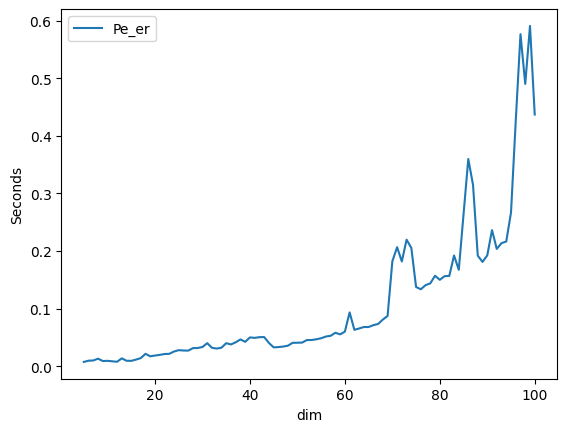

In [620]:
df.plot()
# ax = plt.gca()
# xl = plt.MultipleLocator(0.02)
# ax.xaxis.set_major_locator(xl)
plt.ylabel('Seconds')
plt.show()

In [626]:
data = {'Gusfield': tt_list1, 'Pe_er': tt_list2, 'Len': [5, 6, 7]}
df = pd.DataFrame(data)
df = df.set_index('Len')

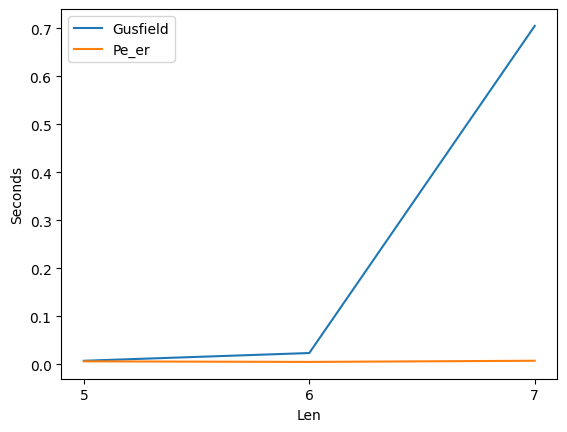

In [475]:
df.plot()
ax = plt.gca()
xl = plt.MultipleLocator(1)
ax.xaxis.set_major_locator(xl)
plt.ylabel('Seconds')
plt.show()

In [595]:
'''
https://github.com/bnmnetp/runestone

The MIT License (MIT)

Copyright (c) 2014 Brad Miller, David Ranum.

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in
all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
THE SOFTWARE.
'''
import numpy as np

class Node:
    def __init__(self,key):
        self.id = key
        self.connectedTo = {}

    def addNeighbor(self,nbr):
        self.connectedTo[nbr] = 0

    def __str__(self):
        return str(self.id) + ' connectedTo: ' + str([x.id for x in self.connectedTo])

    def getConnections(self):
        return self.connectedTo.keys()

    def delConnection(self,key):
        to_del = [n for n in self.connectedTo if n.getId()==key]
        if len(to_del)>0:
            del self.connectedTo[to_del[0]]

    def getId(self):
        return self.id

class Graph:
    def __init__(self):
        self.nodeList = {}
        self.numNodes = 0

    def addNode(self,key):
        self.numNodes = self.numNodes + 1
        newNode = Node(key)
        self.nodeList[key] = newNode
        return newNode

    def getNode(self,n):
        if n in self.nodeList:
            return self.nodeList[n]
        else:
            return None

    def delNode(self,key):
        try:
            node_to_del = self.getNode(key)
            for n in self.nodeList:
                node = self.getNode(n)
                node.delConnection(key)
            del self.nodeList[key]
            self.numNodes = self.numNodes - 1
            return None
        except KeyError:
            raise Exception('Node %s does not exist' % key)

    def __contains__(self,n):
        return n in self.nodeList

    def addEdge(self,f,t,cost=0):
        if f not in self.nodeList:
            nv = self.addNode(f)
        if t not in self.nodeList:
            nv = self.addNode(t)
        self.nodeList[f].addNeighbor(self.nodeList[t])

    def getNodes(self):
        return self.nodeList.keys()

    def __iter__(self):
        return iter(self.nodeList.values())

'''
Author: Marek Cmero
Graph implementation for building incomplete phylogeny _M_ Graphs
'''
class MGraph(Graph):
    def build_graph(self,m,s,c):
        '''
        take the _M_ matrix with its correspoinding samples (s) and
        feature columns (c), returning the corresponding connection graph
        '''
        for si in s:
            self.addNode(si)
        for ci in c:
            self.addNode(ci)

        for i in range(len(m)):
            nc = c[np.where(m[i]==1)]
            for ci in nc:
                self.addEdge(s[i],ci)
        return None

    def get_edge_pairs(self):
        '''
        get all the pairwise connections of the graph
        '''
        pairs = []
        for n in self:
            for w in n.getConnections():
                pairs.append([n.getId(),w.getId()])
        return pairs

    def get_pairs_containing(self,x):
        '''
        get all pairs of conections that contain the element ID x
        '''
        pairs = []
        for pair in self.get_edge_pairs():
            if pair[0]==x or pair[1]==x:
                pairs.append(pair)
        return pairs

In [598]:
import numpy as np

def get_duplicates(items):
    '''
    returns the indices of all duplicates in a list
    @param items a 1D list
    '''
    locs = []

    for i in range(len(items)):
        loc_tmp = [i]
        item = items[i]
        start_at = i+1
        while True:
            try:
                loc = items.index(item,start_at)
            except ValueError:
                break
            else:
                loc_tmp.append(loc)
                start_at = loc + 1

        if len(loc_tmp)>1:
            locs.append(loc_tmp)

    return(locs)

def remove_duplicates(m_prime, c_prime):
    '''
    remove any duplicate columns and merge associated features
    @param m_prime M' matrix
    @param c_prime features list corresponding to columns of M'
    '''
    #print(np.rot90(m_prime)[::-1])
    # add list()
    m_prime_tmp = list(map(lambda x: '.'.join(map(str,x)),np.rot90(m_prime)[::-1]))
    #print(m_prime_tmp)
    dups = get_duplicates(m_prime_tmp)

    n_dup = len(dups)
    to_del = []
    if n_dup > 0:
        for idx,dup in enumerate(dups):
            to_del.extend(dup[1:])
            c_prime[dup[0]] = b'_'.join(c_prime[dup])

    m_prime = np.delete(m_prime,to_del,axis=1)
    c_prime = np.delete(c_prime,to_del)

    return(m_prime, c_prime)

def remove_S_semi_universal(m3,c3):
    '''
    remove any columns that have no 0 entries
    @param m3 the M matrix
    @param c3 column features corresponding to the M matrix
    '''
    mi = np.empty(0,dtype='int')
    ncol = len(m3[0])
    idxs_to_delete = [i for i in range(ncol) if not np.any(m3[:,i]==0)]
    m3 = np.delete(m3,idxs_to_delete,axis=1)
    c3 = np.delete(c3,idxs_to_delete)
    return(m3,c3)

def m_column_sort(m_prime, c_prime):
    m_prime = np.rot90(m_prime)

    # count binary score of columns
    binary_strings = []
    for col in m_prime:
        # change all -1 to 0
        col = np.array([ci if ci>0 else 0  for ci in col])
        col_string = '0b'+''.join(map(str,col))
        binary_strings.append(int(col_string,2))

    # sort by binary score
    order = np.argsort(binary_strings)[::-1]
    m_prime = m_prime[order]
    m_prime = np.rot90(m_prime)[::-1] #rotate again
    c_order = (len(c_prime) - 1) - order #translate order of rotated matrix to order of columns
    c_prime = c_prime[c_order]
    return m_prime,c_prime

def m_initial(m,c):
    '''
    Construct M' matrix, remove S_semi_universal c and duplicates, sort the column
    '''
    m_prime, c_prime = remove_S_semi_universal(m,c)
    m_prime, c_prime = remove_duplicates(m_prime, c_prime)
    m_prime, c_prime = m_column_sort(m_prime, c_prime)

    return m_prime, c_prime

def get_m_prime(m,c):
    '''
    Construct M' matrix
    Obtain binary encoding for each feature, sort by binary value,
    then rotate and reverse the resulting matrix
    @param nshared nxm matrix of samples (cols) and
    @param svrot is true, the matrix is of form rows = svs, cols = samples
    '''
    m_prime, c_prime = remove_duplicates(m, c)
    m_prime = np.rot90(m_prime)

# count binary score of columns
    binary_strings = []
    for col in m_prime:
        col = np.array([ci if ci>0 else 0  for ci in col])
        col_string = '0b'+''.join(map(str,col))
        binary_strings.append(int(col_string,2))

# sort by binary score
    order = np.argsort(binary_strings)[::-1]
    m_prime = m_prime[order]
    m_prime = np.rot90(m_prime)[::-1] #rotate again
    c_order = (len(c_prime) - 1) - order #translate order of rotated matrix to order of columns
    c_prime = c_prime[c_order]

    return(m_prime,c_prime)

def get_k1_matrix(m_prime,features):
    '''
    Generate k1 from m' matrix
    Allows for checking of perfect phylogeny
    @param mp the m prime matrix
    @param nodes corresponding to the matrix
    '''
    ncol = len(m_prime[0])
    k = np.empty( [0,ncol], dtype='|S15' )

    for m in m_prime:
        row_feats = features[m!=0] #features in the row
        mrow = np.zeros(ncol,dtype='|S15')
        mrow.fill('0')

        for idx,feature in enumerate(row_feats):
            mrow[idx] = feature

        n_feat = len(row_feats)
        if n_feat < ncol:
            mrow[n_feat]='#'

        k = np.append(k,[mrow],axis=0)

    return(k)

def get_k1_matrix_new(m_prime,features):
    '''
    Generate k1 from m' matrix
    Allows for checking of perfect phylogeny
    @param mp the m prime matrix
    @param nodes corresponding to the matrix
    '''
    ncol = len(m_prime[0])
    k = np.empty( [0,ncol], dtype='|S15' )

    for m in m_prime:
        row_feats = features[m!=0] #features in the row
        mrow = np.zeros(ncol,dtype='|S15')
        mrow.fill('0')

        for idx,feature in enumerate(row_feats):
            mrow[idx] = feature

        n_feat = len(row_feats)
        if n_feat < ncol:
            mrow[n_feat]='#'

        k = np.append(k,[mrow],axis=0)

    return(k)

def perfect_phylogeny_exists(k1,features):
    '''
    Determine whether perfect phylogeny exists from a k1 matrix
    @param k1 the k1 matrix (output from get_k1_matrix)
    @param features the column features
    '''
    #locations = []
    for feature in features:
        present_at = []
        row_at = []
        for row, k_i in enumerate(k1):
            if len(list(np.where(k_i==feature)[0])) != 0:
                present_at.append(np.where(k_i==feature)[0][0])
                row_at.append(row)
            elif len(list(np.where(k_i==feature)[0])) > 1:
                print('No phylogeny found!')
                return False

        if len(set(present_at)) > 1:
            print('No phylogeny found!')
            return False
        elif len(present_at) != 0:
            col = present_at[0]
            if col == 0:
                pass
            str_set = set([])
            for r in row_at:
                str_r = ""
                for c in range(col):
                    str_r+=str(k1[r][c].decode("utf-8"))
                str_set.add(str_r)
            # print("str_set: ", str_set)
            if len(str_set) > 1:
                print('No phylogeny found!')
                return False

    print('Success! Found phylogeny!\nK1 matrix:')
    print(k1)
    return(True)

def get_connected_componet(k,q,m_graph):
    '''
    return the first K vector with E[K] >= 1
    @param k holds the connection vector, initialise with set()
    @param q chain of connected vertices
    @param m_graph graph object containing matrix connections
    '''
    # find connected components
    if not q:
        return(k)
    else:
        q1 = q.pop()
        k.add(q1)
        pairs = m_graph.get_pairs_containing(q1)
        pairs = set([node for pair in pairs for node in pair]) #flatten set of elements
        for node in pairs:
            if node not in k:
                q.add(node)
        return(get_connected_componet(k,q,m_graph))

def get_S_prime_semi_universal(m3,s,c3,k):
    s_prime   = set(s).intersection(k)    # s in connected component K
    s_indexes = np.array([np.where(s_i==s)[0][0] for s_i in s_prime])
    m_tmp     = m3.copy()[s_indexes]

    print('k:')
    print(k)
    print("S':")
    print(s_prime)

    u = []
    c_in_k  = set(c3).intersection(k)   # c in connected component K
    for c_i in c_in_k:
        c_index = np.where(c_i==c3)[0][0]
        m_col = m_tmp[:,c_index:c_index+1]
        if np.all(m_col!=0):      # c column not all zero ==> s prime semi-universal
            cm = np.where(c_i==c3)[0]
            u.append(c_i)

    return s_prime, u